# **CC6204 - Deep Learning**

## **Predicción de riesgo de diabetes en etapas tempranas**

En esta tarea vas a desarrollar un modelo de aprendizaje que sea capaz de  determinar si una persona tiene riesgo de paceder diabetes en un futuro. Los datos han sido coleccionados a través de encuestas a pacientes en el Sylhet Diabetes Hospital en Bangladesh. Los datos han sido curados y verificados por profesionales de la salud, por lo que son confiables para crear un modelo de aprendizaje.

Primero vamos a importar los paquetes necesarios para trabajar en estos datos.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

np.random.seed(0)


## **Descarga de archivo de datos**
Los datos están disponibles en un archivo CSV que contiene 520 muestras de 17 atributos. Los atributos son:

*   Age: numérico
*   Género: \[Male, Female\]
*   Polyuria
*   Polydipsia
*   sudden weight loss
*   weakness
*   Polyphagia
*   Genital thrush
*   visual blurring
*   Itching
*   Irritability
*   delayed healing
*   partial paresis
*   muscle stiffness
*   Alopecia
*   Obesity
*   Class: \[Positive, Negative\]

Todos los atributos descritos sin valores tienen el conjunto \[Yes, No\].

En la siguiente celda de código, descargamos el archivo y lo leemos con Pandas. Finalmente, visualizamos algunos datos del conjunto.



In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
dataset_path = 'diabetes_data_upload.csv'

--2023-09-20 03:25:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘diabetes_data_upload.csv’

diabetes_data_uploa     [ <=>                ]  33.87K  --.-KB/s    in 0.03s   

2023-09-20 03:25:14 (1.19 MB/s) - ‘diabetes_data_upload.csv’ saved [34682]



In [3]:
import csv

with open('diabetes_data_upload.csv') as inp, open('temp.csv', 'w') as out:
    reader = csv.reader(inp)
    writer = csv.writer(out, delimiter=',')
    #No need to use `insert(), `append()` simply use `+` to concatenate two lists.
    writer.writerow(['ID'] + next(reader))
    #Iterate over enumerate object of reader and pass the starting index as 1.
    writer.writerows([i] + row for i, row in enumerate(reader, 1))

In [4]:
column_names = ['Age','Gender','Polyuria','Polydipsia','sudden weight loss',
                'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring','Itching', 'Irritability', 'delayed healing',
                'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, header=1)

dataset = raw_dataset.copy()
dataset.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
1,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
2,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
3,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
4,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive


# **Pre-procesamiento del conjunto de datos**
El conjunto de datos es variado. El atributo "Age" es el único atributo numérico. Todos los demás atributos son nominales. Para procesar los datos nominales en una red neuronal, es mejor convertirlos a una representación numérica. En el siguiente ejemplo transformamos el atributo "Gender" con valores nominales "Female" y "Male" a valores 1.0 y 0.0, respectivamente.

Del mismo modo, cambiamos los valores nominales de todos los atributos a valores 0.0 y 1.0.

In [5]:
gender = dataset.pop('Gender')
dataset['gender'] = (gender == 'Female')*1.0

column_class = dataset.pop('class')
dataset['class'] = (column_class=='Positive')*1.0

for column in column_names:
  if column not in ['Gender', 'class', 'Age']:
    column_class = dataset.pop(column)
    dataset[column] = (column_class=='Yes')*1.0

# Prueba mostrando parte de la data para ver si tu conversión se hizo correctamente
dataset.tail()


,Age,gender,class,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
514,39,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
515,48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
516,58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
517,32,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
518,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora normalizamos el atributo "Age" y dividimos la data en conjunto de entrenamiento y conjunto de test. Esta división es siempre necesaria para poder probar si tu modelo de aprendizaje ha aprendido a generalizar con datos que no pertenecen al conjunto de entrenamiento.

In [6]:
max_age = dataset["Age"].max()
dataset["Age"] = dataset["Age"] / max_age
dataset.tail()


#80% de datos para train y 20% de datos para test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('class')
test_labels = test_dataset.pop('class')


In [7]:
#Convertimos todo a arrays Numpy
X_train = train_dataset.to_numpy()
X_test = test_dataset.to_numpy()

Y_train = train_labels.to_numpy()
Y_test = test_labels.to_numpy()

Y_train = Y_train[:,None]
Y_test = Y_test[:,None]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(415, 16)
(415, 1)
(104, 16)
(104, 1)


# **Parte 1**
Diseña y entrena un perceptrón multicapa con la data de arriba. Intenta que tu modelo alcance el mayor accuracy de test posible (ojalá por encima del 93%). Para este primer experimento puedes usar la implementación de MLP vista en clase (basada en Numpy) ó puedes usar algún framework como Tensorflow o Pytorch si es que deseas. Hay que tener en cuenta algunas consideraciones para este primer experimento:



*   Usar gradiente descendiente estocástico con un tamaño de mini-batch de 20.
*   Usar learning rate de 0.01.
*  Los mini-batches NO se generan de manera aleatoria.

Graficar la función de loss con respecto a las épocas.

In [8]:

class Linear:
    """Clase que describe una capa fully connected (sin función de activación)."""

    # Constructor - definimos los parámetros de esta capa
    def __init__(self, num_inputs, num_outputs, learning_rate, name):
      # Loa parámetros se inicializan de forma aleatoria - distribución uniforme (0,1)
      self.W = np.random.rand(num_inputs, num_outputs) # Matriz de pesos de la capa (in x out)
      self.b = np.zeros((num_outputs, 1)) # Bias de la capa (out x 1)
      self.lr = learning_rate # Learning rate
      self.name = name # Nombre de la capa

    # input: mini-batch (batch_size x in)
    # Función que opera la función lineal de la capa
    def forward(self, input):
      self.inputs = input
      return np.dot(self.inputs, self.W) + self.b.T

    # dy: Error de la capa siguiente (batch_size x out)
    # Función que recibe el error de la capa siguiente y computa el error de esta capa
    def backward(self, dy):
      batch_size = dy.shape[0]
      dy = dy.T # (out x batch_size)
      dw = dy.dot(self.inputs) #(out x in)
      db = np.sum(dy, axis=1, keepdims=True) #(out x 1)
      dx = np.dot(dy.T, self.W.T) # (batch_size x out) x (out x in)

      # Reglas de actualización del método SGD
      self.W -= (self.lr/batch_size)*dw.T
      self.b -= (self.lr/batch_size)*db

      # La función retorna el error de esta capa para realizar su retropropagación
      return dx


# FUNCIONES DE ACTIVACIÓN RELU Y SIGMOIDE

class ReLU:
  """Clase que define a la función de activación ReLU."""

  def __init__(self):
    pass

  # Función que computa la función ReLU
  def forward(self, input):
    self.input = input
    ret = input.copy()
    ret[ret<0] = 0
    return ret

  # Función que permite retropropagar el error entrante utilizando la derivada de
  # la función ReLU
  def backward(self, dy):
    dx = dy.copy()
    dx[self.input<0] = 0
    return dx


class Sigmoid:
    """Clase que define a la función se activación Sigmoide."""

    def __init__(self):
      pass

    # Función que computa la función Sigmoide
    def forward(self, inputs):
      self.output = 1/(1 + np.exp(-inputs))
      return self.output

    # Función que permite retropropagar el error entrante utilizando la derivada de
    # la función Sigmoide
    def backward(self, dy):
      return dy*self.output*(1-self.output) # dy/4

In [9]:
# Loss function: Función que calcula la pérdida utilizando Mean Squared Error (MSE)
def mse(output, labels):
  return 0.5*np.sum((output-labels)**2)

# Clase del MLP
class MLPReLU:
    """Clase que implementa una red neuronal multicapa(MLP) para clasificación binaria."""

    def __init__(self, learning_rate):
      # La clase recibe como input el lerning rate
      # Se generan las capas del modelo. En este caso se crean dos capas utilizando
      # la función de activación ReLU y Sigmoide
      self.layers = []
      self.layers.append(Linear(num_inputs=16, num_outputs=9, learning_rate=learning_rate, name='fc1'))
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=9, num_outputs=1, learning_rate=learning_rate,  name='fc2'))
      self.layers.append(Sigmoid())
      self.num_layers = len(self.layers)

    # Función que realiza el entrenamiento de la red neuronal utilizando los mini-batches del algoritmo SGD
    def train(self, training_data, training_label, batch_size, epoch, test_data, test_label,verbose=False):

      # Historial de los valores de pérdida de entrenamiento y prueba
      train_loss = []
      test_loss = []

      # Iterador principal sobre cada época
      for e in range(epoch):

        # TRAIN
        # Realización de una época de entrenamiento
        loss = 0

        # Iteración sobre cada mini-batch
        for batch_index in range(0, training_data.shape[0], batch_size):
          # Verificación si el mini-batch cumple con el batch_size
          if batch_index+batch_size < training_data.shape[0]:
            data = training_data[batch_index:batch_index+batch_size]
            label = training_label[batch_index:batch_index+batch_size]
          # Si no alcanza el batch_size se genera con un tamaño menor
          else:
            data = training_data[batch_index:training_data.shape[0]]
            label = training_label[batch_index:training_label.shape[0]]

          acc = 0

          # Forward pass - iteración sobre la lista de capas
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output

          # Primer error - derivada de la función de costo con respecto a la salida de la red neuronal
          dy = output - label
          loss += mse(output, label) # Computo de la pérdida de entrenamiento

          # Backpropagation - iteración sobre la lista de capas en reversa
          for l in range(self.num_layers-1, -1, -1):
            dout = self.layers[l].backward(dy)
            dy = dout

         # Finalización de una época
        loss /= training_data.shape[0]
        train_loss.append(loss) # Registramos la pérdidad de la época en el historial

        #TEST

        # Prueba sobre cada época
        loss = 0
        outputs = []

        correct = 0
        for batch_index in range(0, test_data.shape[0], batch_size):
          if batch_index+batch_size < test_data.shape[0]:
            data = test_data[batch_index:batch_index+batch_size]
            label = test_label[batch_index:batch_index+batch_size]
          else:
            data = test_data[batch_index:test_data.shape[0]]
            label = test_label[batch_index:test_label.shape[0]]

          acc = 0

          # Forward pass
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output

          loss += mse(output, label) # Computamos la pérdida de prueba

          test_output = (output >= 0.5) # Definimos el umbral para etiquetar la salida de la red a datos binarios(0 y 1)

          correct += (test_output == label).sum() # Comparación de la salida de la red con las etiquetas de los datos de prueba

        # Finalización de prueba de la época
        loss /= test_data.shape[0]
        test_loss.append(loss)

        # Se retorna los resultados de prueba en cada época
        if verbose:
          print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))
        else:
          if e % 20 == 0:
            print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))

      return dict({'train_loss': train_loss, 'test_loss':test_loss})

    # Función que evalua el rendimiento de la red neuronal sobre un conjunto de datos
    def evaluate(self, data, label, batch_size):

      correct = 0
      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
          nlabel = label[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
          nlabel = label[batch_index:label.shape[0]]

        # Forward pass
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output

        test_output = (output >= 0.5) # Definimos el umbral para etiquetar la salida de la red a datos binarios(0 y 1)

        correct += (test_output == nlabel).sum() # Comparación de la salida de la red con las etiquetas de los datos de prueba

      # La función retorna el accuracy de la red neuronal en porcentaje
      return (100*correct)/label.shape[0]

    # Función que retorna las predicciones de la red neuronal sobre un conjunto de datos
    def predict(self, data, batch_size):

      output_pred = []
      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]

        # Forward pass
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output

        test_output = (output >= 0.5) # Definimos el umbral para etiquetar la salida de la red a datos binarios(0 y 1)

        output_pred.append(test_output) # Registramos las predicciones realizadas por el modelo

      # La función retorna un stack de arrays con las predicciones sobre cada mini-batch
      return np.vstack(output_pred)


In [10]:
start_time = time.time()
# Parámetros para el entrenamiento y evaluación del modelo
LEARNING_RATE = 0.01
BATCH_SIZE = 20
EPOCHS = 1000

net = MLPReLU(learning_rate=LEARNING_RATE)
history = net.train(X_train, Y_train, BATCH_SIZE, EPOCHS, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, BATCH_SIZE), net.evaluate(X_test, Y_test, BATCH_SIZE)))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0/1000: loss = 0.16760481258668986: Test accuracy=61.53846153846154
Epoch 20/1000: loss = 0.16210882007379324: Test accuracy=61.53846153846154
Epoch 40/1000: loss = 0.15598402980923584: Test accuracy=61.53846153846154
Epoch 60/1000: loss = 0.1497723373648066: Test accuracy=61.53846153846154
Epoch 80/1000: loss = 0.14516645143978305: Test accuracy=69.23076923076923
Epoch 100/1000: loss = 0.14188446346637099: Test accuracy=73.07692307692308
Epoch 120/1000: loss = 0.13915203470298768: Test accuracy=73.07692307692308
Epoch 140/1000: loss = 0.13677780000071438: Test accuracy=73.07692307692308
Epoch 160/1000: loss = 0.13431899399896216: Test accuracy=73.07692307692308
Epoch 180/1000: loss = 0.13154004729508648: Test accuracy=73.07692307692308
Epoch 200/1000: loss = 0.1280779707465268: Test accuracy=74.03846153846153
Epoch 220/1000: loss = 0.12338990643707137: Test accuracy=74.03846153846153
Epoch 240/1000: loss = 0.11625936250679482: Test accuracy=75.0
Epoch 260/1000: loss = 0.10342894

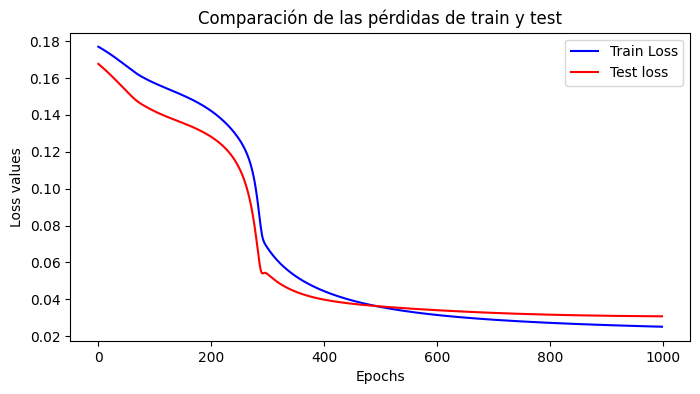

In [11]:
# Visualización de las pérdidas de train y test

plt.figure(figsize=(8,4))
plt.plot(history['train_loss'], color='b', label='Train Loss')
plt.plot(history['test_loss'], color='r', label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.title('Comparación de las pérdidas de train y test')
plt.legend()
plt.show()

En el diseño del modelo MLP, se optó por una estructura de 2 capas, cada una con 9 neuronas. Esta elección se basó en su excelente rendimiento, evidenciado por un alto valor de accuracy sobre el conjunto de entrenamiento y una baja cantidad de práametros por computar.

El proceso de entrenamiento de este modelo se llevó a cabo a lo largo de 1000 épocas, utilizando un learning rate de 0.01 y un batch size de 20. Como resultado, se obtuvo un accuracy sobre el conjunto de entrenamiento de 93.26%, con un tiempo de cómputo de aproximadamente 1.9 segundos. Además se pudo visualizar en el gráfico anterior que las pérdidas del modelo durante su entrenamiento disminuyeron drásticamente entre las épocas 200 y 400, lo cual refleja la dificultad del modelo para converger. Por otra parte, entre las épocas 400 y 600 se pudo visualizar como la curva de las pérdidas de test comenzó a interceptar la curva de pérdidas de train, lo cual implica un cierto grado de overfiting en el resultado del entrenamiento del modelo.

Para abordar estos problemas, se podrían considerar enfoques como la inicialización de Kaiming He para acelerar la convergencia del modelo y la aplicación de regularización L2 para contrarrestar el overfitting.


# **Parte 2**
Intenta cambiar el tamaño de los mini-batches. Como casos extremos usa m=1 (mini-batches de tamaño 1) y m=n(1 solo mini-batch con todos los datos). Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

## Caso batch size = 1

In [12]:
# Caso de batch_size=1

start_time = time.time()
# Parámetros para el entrenamiento y evaluación del modelo
LEARNING_RATE = 0.01
BATCH_SIZE = 1
EPOCHS = 1000

net_batch_1 = MLPReLU(learning_rate=LEARNING_RATE)
history_batch_1 = net_batch_1.train(X_train, Y_train, BATCH_SIZE, EPOCHS, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net_batch_1 .evaluate(X_train, Y_train, BATCH_SIZE), net_batch_1 .evaluate(X_test, Y_test, BATCH_SIZE)))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0/1000: loss = 0.16162752806682915: Test accuracy=61.53846153846154
Epoch 20/1000: loss = 0.0890669210060864: Test accuracy=78.84615384615384
Epoch 40/1000: loss = 0.03645888931312237: Test accuracy=92.3076923076923
Epoch 60/1000: loss = 0.03215237343975744: Test accuracy=91.34615384615384
Epoch 80/1000: loss = 0.03249844586753115: Test accuracy=89.42307692307692
Epoch 100/1000: loss = 0.0333779925885564: Test accuracy=91.34615384615384
Epoch 120/1000: loss = 0.034208568781850614: Test accuracy=91.34615384615384
Epoch 140/1000: loss = 0.03495678134485104: Test accuracy=91.34615384615384
Epoch 160/1000: loss = 0.035621965368737844: Test accuracy=92.3076923076923
Epoch 180/1000: loss = 0.03619921756194066: Test accuracy=92.3076923076923
Epoch 200/1000: loss = 0.03667042908609303: Test accuracy=92.3076923076923
Epoch 220/1000: loss = 0.03703347594326823: Test accuracy=92.3076923076923
Epoch 240/1000: loss = 0.03729323779896695: Test accuracy=92.3076923076923
Epoch 260/1000: loss = 0

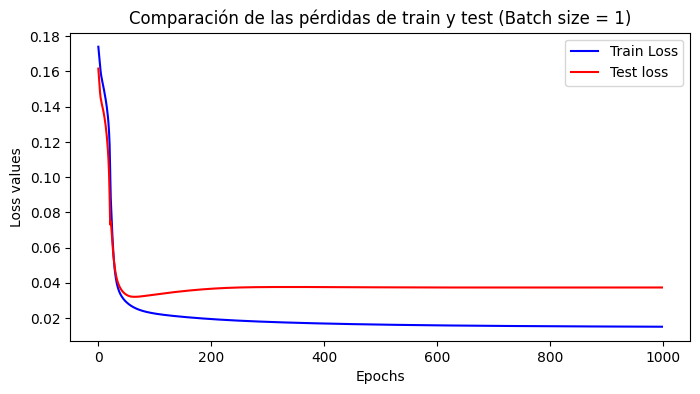

In [13]:
# Visualización de las pérdidas de train y test

plt.figure(figsize=(8,4))
plt.plot(history_batch_1['train_loss'], color='b', label='Train Loss')
plt.plot(history_batch_1['test_loss'], color='r', label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.title('Comparación de las pérdidas de train y test (Batch size = 1)')
plt.legend()
plt.show()

## Caso batch size = 207

In [19]:
# Caso de batch_size=mitad del tamaño total de datos

start_time = time.time()
# Parámetros para el entrenamiento y evaluación del modelo
LEARNING_RATE = 0.01
BATCH_SIZE = 207
EPOCHS = 1000

net_batch_207 = MLPReLU(learning_rate=LEARNING_RATE)
history_batch_207 = net_batch_207.train(X_train, Y_train, BATCH_SIZE, EPOCHS, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net_batch_207.evaluate(X_train, Y_train, BATCH_SIZE), net_batch_207.evaluate(X_test, Y_test, BATCH_SIZE)))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0/1000: loss = 0.16461716699858675: Test accuracy=61.53846153846154
Epoch 20/1000: loss = 0.16417824285323854: Test accuracy=61.53846153846154
Epoch 40/1000: loss = 0.16373495454890913: Test accuracy=61.53846153846154
Epoch 60/1000: loss = 0.16328748122353431: Test accuracy=61.53846153846154
Epoch 80/1000: loss = 0.16283601151419985: Test accuracy=61.53846153846154
Epoch 100/1000: loss = 0.16238074310717904: Test accuracy=61.53846153846154
Epoch 120/1000: loss = 0.161921882220921: Test accuracy=61.53846153846154
Epoch 140/1000: loss = 0.16145964302350377: Test accuracy=61.53846153846154
Epoch 160/1000: loss = 0.16099424698684783: Test accuracy=61.53846153846154
Epoch 180/1000: loss = 0.1605259221807678: Test accuracy=61.53846153846154
Epoch 200/1000: loss = 0.16005490251071147: Test accuracy=61.53846153846154
Epoch 220/1000: loss = 0.15958142690377322: Test accuracy=61.53846153846154
Epoch 240/1000: loss = 0.15910573844826553: Test accuracy=61.53846153846154
Epoch 260/1000: loss 

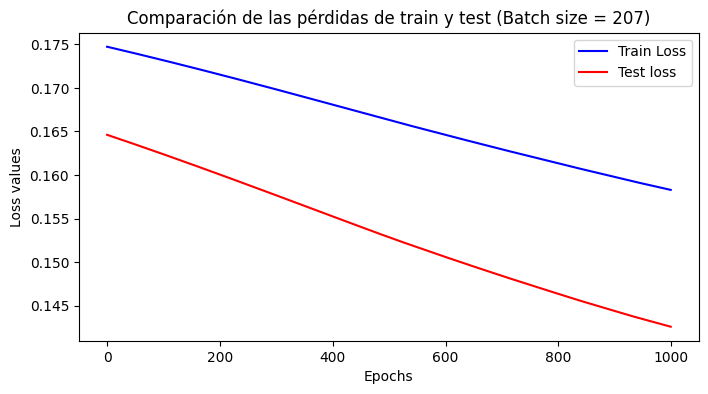

In [20]:
# Visualización de las pérdidas de train y test

plt.figure(figsize=(8,4))
plt.plot(history_batch_207['train_loss'], color='b', label='Train Loss')
plt.plot(history_batch_207['test_loss'], color='r', label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.title('Comparación de las pérdidas de train y test (Batch size = 207)')
plt.legend()
plt.show()

## Caso batch size = 415

In [21]:
# Caso de batch_size=tamaño del total de datos

start_time = time.time()
# Parámetros para el entrenamiento y evaluación del modelo
LEARNING_RATE = 0.01
BATCH_SIZE = 415
EPOCHS = 1000

net_batch_415 = MLPReLU(learning_rate=LEARNING_RATE)
history_batch_415 = net_batch_415.train(X_train, Y_train, BATCH_SIZE, EPOCHS, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net_batch_415.evaluate(X_train, Y_train, BATCH_SIZE), net_batch_415.evaluate(X_test, Y_test, BATCH_SIZE)))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0/1000: loss = 0.15376126594711817: Test accuracy=61.53846153846154
Epoch 20/1000: loss = 0.15343008270167519: Test accuracy=61.53846153846154
Epoch 40/1000: loss = 0.15309576874806816: Test accuracy=61.53846153846154
Epoch 60/1000: loss = 0.15275824927045106: Test accuracy=61.53846153846154
Epoch 80/1000: loss = 0.15241744396324627: Test accuracy=61.53846153846154
Epoch 100/1000: loss = 0.1520732666114428: Test accuracy=61.53846153846154
Epoch 120/1000: loss = 0.15172562463771505: Test accuracy=61.53846153846154
Epoch 140/1000: loss = 0.1513744186132948: Test accuracy=61.53846153846154
Epoch 160/1000: loss = 0.15101954172919616: Test accuracy=61.53846153846154
Epoch 180/1000: loss = 0.15066087922402704: Test accuracy=61.53846153846154
Epoch 200/1000: loss = 0.15029830776420644: Test accuracy=61.53846153846154
Epoch 220/1000: loss = 0.14993169477194507: Test accuracy=61.53846153846154
Epoch 240/1000: loss = 0.1495608976958285: Test accuracy=61.53846153846154
Epoch 260/1000: loss 

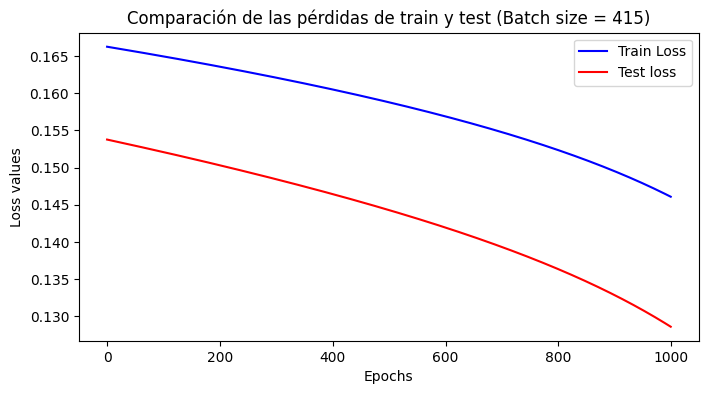

In [22]:
# Visualización de las pérdidas de train y test

plt.figure(figsize=(8,4))
plt.plot(history_batch_415['train_loss'], color='b', label='Train Loss')
plt.plot(history_batch_415['test_loss'], color='r', label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.title('Comparación de las pérdidas de train y test (Batch size = 415)')
plt.legend()
plt.show()

Se reconoce que el valor de batch size es un hiperparámetro de gran importancia en el entrenamiento de modelos basados en redes neuronales. Uno de sus objetivos principales radica en la gestión eficiente de la memoria durante el proceso de cálculo. Un menor tamaño de los mini-batches consume menos memoria, mientras que un batch size más grande requiere más recursos, lo que incide de manera significativa en la eficiencia del entrenamiento.

En los resultados obtenidos, se notó que el tamaño de los mini-batches impactó directamente en la velocidad de convergencia del modelo. Con un valor de batch size pequeño, en este caso 1, se necesitó un tiempo considerable de 34 segundos para alcanzar la convergencia. Esto se debe a que cada mini-batch corresponde a un solo dato del conjunto de datos, aumentando la complejidad computacional. En cambio, con valores de batch size más grandes, como la mitad o la totalidad del conjunto de datos, la convergencia se logró de manera inmediata, aprovechando al máximo la paralelización de los cálculos.

Además, observamos que el valor del tamaño del mini-batch influye directamente en la capacidad de generalización del modelo. Con un valor de batch size igual a 1, el modelo alcanzó unalto accuracy sobre los datos de test, pero mostró un evidente overfitting. Por otro lado, con valores de batch size más grandes, se obtuvieron valores de accuracy sobre los datos de test más bajos, pero sin signos de overfitting.

Finalmente, al comparar los gráficos de esta sección con los de la Parte 1, se evidencia que con valores de batch size más grandes, la convergencia es más rápida, a diferencia de la Parte 1, donde la curva de pérdida se mantuvo elevada hasta disminuir significativamente entre las épocas 200 y 400. En cambio, con un valor de batch size igual a 1, la convergencia ocurrió entre las primeras 200 épocas, pero con un mayor tiempo de cálculo y un notorio overfitting en los resultados.




# **Parte 3**
Intenta cambiar el learning rate. Como casos extremos usa lr = 0.5 y lr = 0.000001. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

## Caso learning rate = 0.5

In [23]:
# Caso de learning rate = 0.5

start_time = time.time()
# Parámetros para el entrenamiento y evaluación del modelo
LEARNING_RATE = 0.5
BATCH_SIZE = 20
EPOCHS = 1000

net_lr_05 = MLPReLU(learning_rate=LEARNING_RATE)
history_lr_05 = net_lr_05.train(X_train, Y_train, BATCH_SIZE, EPOCHS, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net_lr_05.evaluate(X_train, Y_train, BATCH_SIZE), net_lr_05.evaluate(X_test, Y_test, BATCH_SIZE)))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0/1000: loss = 0.15379928628565237: Test accuracy=61.53846153846154
Epoch 20/1000: loss = 0.034001087284243156: Test accuracy=92.3076923076923
Epoch 40/1000: loss = 0.038394255886733966: Test accuracy=91.34615384615384
Epoch 60/1000: loss = 0.03878367513040692: Test accuracy=91.34615384615384
Epoch 80/1000: loss = 0.038915441709132095: Test accuracy=91.34615384615384
Epoch 100/1000: loss = 0.03899486622002879: Test accuracy=92.3076923076923
Epoch 120/1000: loss = 0.038939808610627: Test accuracy=92.3076923076923
Epoch 140/1000: loss = 0.03881182205560622: Test accuracy=92.3076923076923
Epoch 160/1000: loss = 0.038668581532516: Test accuracy=92.3076923076923
Epoch 180/1000: loss = 0.03855865616248054: Test accuracy=92.3076923076923
Epoch 200/1000: loss = 0.03849735318306443: Test accuracy=92.3076923076923
Epoch 220/1000: loss = 0.038481182513445976: Test accuracy=92.3076923076923
Epoch 240/1000: loss = 0.038495218322916976: Test accuracy=92.3076923076923
Epoch 260/1000: loss = 0.0

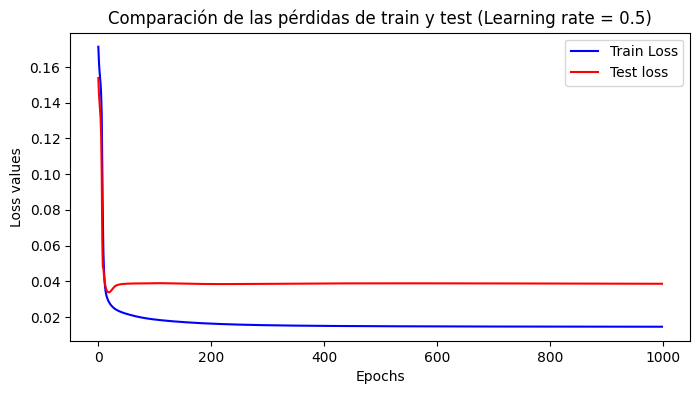

In [24]:
# Visualización de las pérdidas de train y test

plt.figure(figsize=(8,4))
plt.plot(history_lr_05['train_loss'], color='b', label='Train Loss')
plt.plot(history_lr_05['test_loss'], color='r', label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.title('Comparación de las pérdidas de train y test (Learning rate = 0.5)')
plt.legend()
plt.show()

## Caso learning rate = 0.000001

In [25]:
# Caso de learning rate = 0.000001

start_time = time.time()
# Parámetros para el entrenamiento y evaluación del modelo
LEARNING_RATE = 0.000001
BATCH_SIZE = 20
EPOCHS = 1000

net_lr_000001 = MLPReLU(learning_rate=LEARNING_RATE)
history_lr_000001 = net_lr_000001.train(X_train, Y_train, BATCH_SIZE, EPOCHS, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net_lr_000001.evaluate(X_train, Y_train, BATCH_SIZE), net_lr_000001.evaluate(X_test, Y_test, BATCH_SIZE)))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0/1000: loss = 0.1589582774009268: Test accuracy=61.53846153846154
Epoch 20/1000: loss = 0.15895774437591045: Test accuracy=61.53846153846154
Epoch 40/1000: loss = 0.15895721134892377: Test accuracy=61.53846153846154
Epoch 60/1000: loss = 0.15895667831996693: Test accuracy=61.53846153846154
Epoch 80/1000: loss = 0.15895614528904053: Test accuracy=61.53846153846154
Epoch 100/1000: loss = 0.15895561225614493: Test accuracy=61.53846153846154
Epoch 120/1000: loss = 0.1589550792212805: Test accuracy=61.53846153846154
Epoch 140/1000: loss = 0.15895454618444763: Test accuracy=61.53846153846154
Epoch 160/1000: loss = 0.15895401314564678: Test accuracy=61.53846153846154
Epoch 180/1000: loss = 0.1589534801048784: Test accuracy=61.53846153846154
Epoch 200/1000: loss = 0.1589529470621428: Test accuracy=61.53846153846154
Epoch 220/1000: loss = 0.15895241401744048: Test accuracy=61.53846153846154
Epoch 240/1000: loss = 0.15895188097077181: Test accuracy=61.53846153846154
Epoch 260/1000: loss =

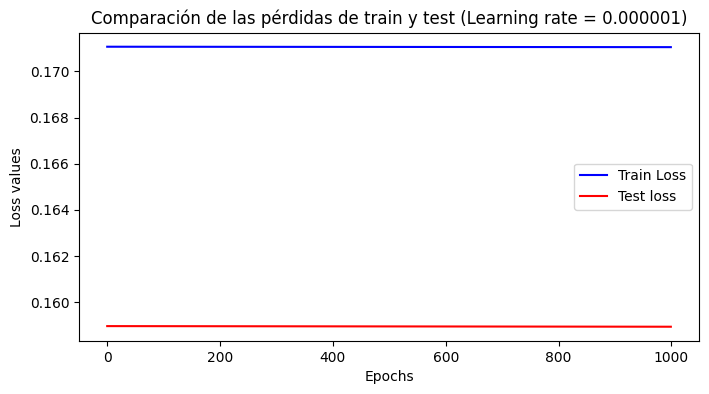

In [26]:
# Visualización de las pérdidas de train y test

plt.figure(figsize=(8,4))
plt.plot(history_lr_000001['train_loss'], color='b', label='Train Loss')
plt.plot(history_lr_000001['test_loss'], color='r', label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.title('Comparación de las pérdidas de train y test (Learning rate = 0.000001)')
plt.legend()
plt.show()

## Caso learning rate = 50

In [27]:
# Caso de learning rate = 50

start_time = time.time()
# Parámetros para el entrenamiento y evaluación del modelo
LEARNING_RATE = 50
BATCH_SIZE = 20
EPOCHS = 1000

net_lr_50 = MLPReLU(learning_rate=LEARNING_RATE)
history_lr_50 = net_lr_50.train(X_train, Y_train, BATCH_SIZE, EPOCHS, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net_lr_50.evaluate(X_train, Y_train, BATCH_SIZE), net_lr_50.evaluate(X_test, Y_test, BATCH_SIZE)))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0/1000: loss = 0.30694936371773623: Test accuracy=38.46153846153846
Epoch 20/1000: loss = 0.02210116276272064: Test accuracy=95.1923076923077
Epoch 40/1000: loss = 0.021666695684867236: Test accuracy=95.1923076923077
Epoch 60/1000: loss = 0.022990149836947003: Test accuracy=94.23076923076923
Epoch 80/1000: loss = 0.021597339980812296: Test accuracy=94.23076923076923
Epoch 100/1000: loss = 0.02302792100380444: Test accuracy=94.23076923076923
Epoch 120/1000: loss = 0.021111702367241827: Test accuracy=94.23076923076923
Epoch 140/1000: loss = 0.021433447003396063: Test accuracy=94.23076923076923
Epoch 160/1000: loss = 0.023424312278509586: Test accuracy=94.23076923076923
Epoch 180/1000: loss = 0.02010105847545474: Test accuracy=94.23076923076923
Epoch 200/1000: loss = 0.022361598810622947: Test accuracy=94.23076923076923
Epoch 220/1000: loss = 0.022637720702820836: Test accuracy=94.23076923076923
Epoch 240/1000: loss = 0.02110892173230696: Test accuracy=94.23076923076923
Epoch 260/10

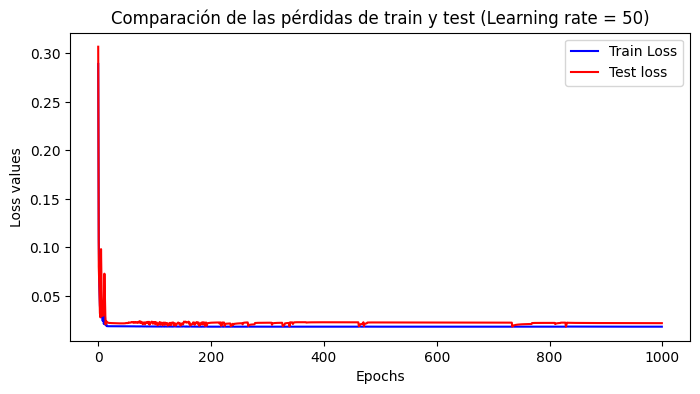

In [28]:
# Visualización de las pérdidas de train y test

plt.figure(figsize=(8,4))
plt.plot(history_lr_50['train_loss'], color='b', label='Train Loss')
plt.plot(history_lr_50['test_loss'], color='r', label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.title('Comparación de las pérdidas de train y test (Learning rate = 50)')
plt.legend()
plt.show()

A partir de los resultados anteriores se pudo visualizar la influencia del learning rate en el entrenamiento de los modelos de redes neuronales. Primero que todo se puede observar que el valor de learning rate influyó directamente en el tiempo de convergencia, en particular con valores bajos se demoró menos tiempo en converger en comparación con los tiempos que se obtuevieron con valores altos de learning rate, sin embargo esto está asociado a la estabilidad con la que converge el modelo, porque con un valor muy alto de learning rate, en esta caso 50, puede que se haya demorado más en converger debido que no logra converger al valor óptimo producto de que el paso es muy alto, aunque con valoroes de learning rate bajos también puede diverger el modelo, lo cual depende mucho de la inicialización de los parámetros que pueden provocar que el modelo no encuentre el camino directo al resultado óptimo de manera inmediata.

Los gráficos generados permitieron apreciar el impacto directo del learning rate en la generalización y la estabilidad de la convergencia del modelo. Por ejemplo, al utilizar un learning rate de 0.00001, el modelo convergió hacia una baja precisión en los datos de prueba (61.53%), y esta precisión se mantuvo constante en todas las épocas. Asimismo, se observó un bajo rendimiento en los datos de entrenamiento, lo que sugiere que un learning rate excesivamente bajo impidió que el modelo aprendiera de manera efectiva y generalizara adecuadamente.

En contraste, con valores más elevados de learning rate, como 0.5, se logró una convergencia en un menor número de épocas en comparación con la Parte 1, pero esta convergencia se caracterizó por un alto grado de sobreajuste, indicando una deficiente generalización durante el entrenamiento.

Por último, con un learning rate considerablemente alto, se logró una convergencia rápida en las primeras épocas, con una alta precisión en los datos de prueba (94.23%) y un bajo nivel de sobreajuste. Sin embargo, se evidenció cierta inestabilidad en la convergencia debido al valor extremadamente alto del learning rate, lo que podría haber causado fluctuaciones en el modelo en torno al óptimo.

# **Parte 4**
Implementar el algoritmo de gradiente descendente estocástico de manera que los mini-batches se generen de manera aleatoria antes de cada época. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [29]:
# Clase del MLP con mini-batches aleatorios
class MLPRandomBatch:
    """Clase que implementa una red neuronal multicapa(MLP) para clasificación binaria."""

    def __init__(self, learning_rate):
      # La clase recibe como input el lerning rate
      # Se generan las capas del modelo. En este caso se crean dos capas utilizando
      # la función de activación ReLU y Sigmoide
      self.layers = []
      self.layers.append(Linear(num_inputs=16, num_outputs=9, learning_rate=learning_rate, name='fc1'))
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=9, num_outputs=1, learning_rate=learning_rate, name='fc2'))
      self.layers.append(Sigmoid())
      self.num_layers = len(self.layers)

    # Función que realiza el entrenamiento de la red neuronal utilizando los mini-batches del algoritmo SGD
    def train(self, training_data, training_label, batch_size, epoch, test_data, test_label,verbose=False):

      # Historial de los valores de pérdida de entrenamiento y prueba
      train_loss = []
      test_loss = []

      # Iterador principal sobre cada época
      for e in range(epoch):

        # Generación aleatoria de los mini-batches
        # Reorganiza aleatoriamente los datos de entrenamiento antes de cada época
        permutation = np.random.permutation(training_data.shape[0])
        shuffled_data = training_data[permutation]
        shuffled_labels = training_label[permutation]

        # TRAIN
        # Realización de una época de entrenamiento
        loss = 0

        # Iteración sobre cada mini-batch
        for batch_index in range(0, shuffled_data.shape[0], batch_size):
          # Verificación si el mini-batch cumple con el batch_size
          if batch_index+batch_size < shuffled_data.shape[0]:
            data = shuffled_data[batch_index:batch_index+batch_size]
            label = shuffled_labels[batch_index:batch_index+batch_size]
          # Si no alcanza el batch_size se genera con un tamaño menor
          else:
            data = shuffled_data[batch_index:shuffled_data.shape[0]]
            label = shuffled_labels[batch_index:shuffled_data.shape[0]]

          acc = 0

          # Forward pass - iteración sobre la lista de capas
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output

          # Primer error - derivada de la función de costo con respecto a la salida de la red neuronal
          dy = output - label
          loss += mse(output, label) # Computo de la pérdida de entrenamiento

          # Backpropagation - iteración sobre la lista de capas en reversa
          for l in range(self.num_layers-1, -1, -1):
            dout = self.layers[l].backward(dy)
            dy = dout

         # Finalización de una época
        loss /= shuffled_data.shape[0]
        train_loss.append(loss) # Registramos la pérdidad de la época en el historial

        #TEST

        # Prueba sobre cada época
        loss = 0
        outputs = []

        correct = 0
        for batch_index in range(0, test_data.shape[0], batch_size):
          if batch_index+batch_size < test_data.shape[0]:
            data = test_data[batch_index:batch_index+batch_size]
            label = test_label[batch_index:batch_index+batch_size]
          else:
            data = test_data[batch_index:test_data.shape[0]]
            label = test_label[batch_index:test_label.shape[0]]

          acc = 0

          # Forward pass
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output

          loss += mse(output, label) # Computamos la pérdida de prueba

          test_output = (output >= 0.5) # Definimos el umbral para etiquetar la salida de la red a datos binarios(0 y 1)

          correct += (test_output == label).sum() # Comparación de la salida de la red con las etiquetas de los datos de prueba

        # Finalización de prueba de la época
        loss /= test_data.shape[0]
        test_loss.append(loss)

        # Se retorna los resultados de prueba en cada época
        if verbose:
          print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))
        else:
          if e % 20 == 0:
            print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))

      return dict({'train_loss': train_loss, 'test_loss':test_loss})

    # Función que evalua el rendimiento de la red neuronal sobre un conjunto de datos
    def evaluate(self, data, label, batch_size):

      correct = 0
      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
          nlabel = label[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
          nlabel = label[batch_index:label.shape[0]]

        # Forward pass
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output

        test_output = (output >= 0.5) # Definimos el umbral para etiquetar la salida de la red a datos binarios(0 y 1)

        correct += (test_output == nlabel).sum() # Comparación de la salida de la red con las etiquetas de los datos de prueba

      # La función retorna el accuracy de la red neuronal en porcentaje
      return (100*correct)/label.shape[0]

    # Función que retorna las predicciones de la red neuronal sobre un conjunto de datos
    def predict(self, data, batch_size):

      output_pred = []
      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]

        # Forward pass
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output

        test_output = (output >= 0.5) # Definimos el umbral para etiquetar la salida de la red a datos binarios(0 y 1)

        output_pred.append(test_output) # Registramos las predicciones realizadas por el modelo

      # La función retorna un stack de arrays con las predicciones sobre cada mini-batch
      return np.vstack(output_pred)

In [32]:
start_time = time.time()
# Parámetros para el entrenamiento y evaluación del modelo
LEARNING_RATE = 0.01
BATCH_SIZE = 20
EPOCHS = 1000

net_random = MLPRandomBatch(learning_rate=LEARNING_RATE)
history_random = net_random.train(X_train, Y_train, BATCH_SIZE, EPOCHS, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net_random.evaluate(X_train, Y_train, BATCH_SIZE), net_random.evaluate(X_test, Y_test, BATCH_SIZE)))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0/1000: loss = 0.1616730759215909: Test accuracy=61.53846153846154
Epoch 20/1000: loss = 0.15685686853891131: Test accuracy=61.53846153846154
Epoch 40/1000: loss = 0.1519286956808561: Test accuracy=61.53846153846154
Epoch 60/1000: loss = 0.14694699440522294: Test accuracy=61.53846153846154
Epoch 80/1000: loss = 0.14203719154301506: Test accuracy=69.23076923076923
Epoch 100/1000: loss = 0.13693780432897779: Test accuracy=73.07692307692308
Epoch 120/1000: loss = 0.13126255339032397: Test accuracy=73.07692307692308
Epoch 140/1000: loss = 0.12469566331378117: Test accuracy=73.07692307692308
Epoch 160/1000: loss = 0.11679839214864242: Test accuracy=73.07692307692308
Epoch 180/1000: loss = 0.10681910981724803: Test accuracy=77.88461538461539
Epoch 200/1000: loss = 0.09250825983837069: Test accuracy=79.8076923076923
Epoch 220/1000: loss = 0.08244851131808531: Test accuracy=76.92307692307692
Epoch 240/1000: loss = 0.07735876537294942: Test accuracy=76.92307692307692
Epoch 260/1000: loss 

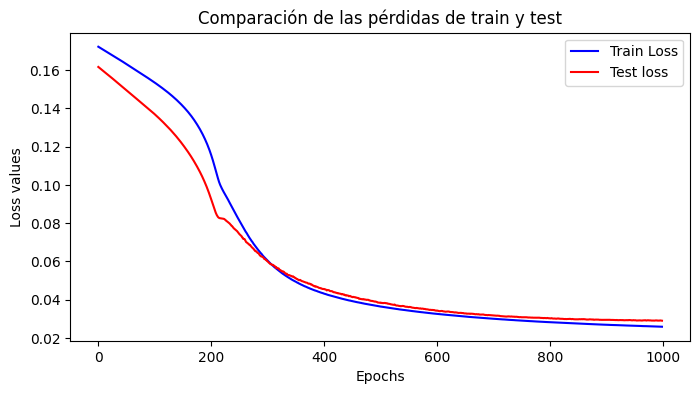

In [33]:
# Visualización de las pérdidas de train y test

plt.figure(figsize=(8,4))
plt.plot(history_random['train_loss'], color='b', label='Train Loss')
plt.plot(history_random['test_loss'], color='r', label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.title('Comparación de las pérdidas de train y test')
plt.legend()
plt.show()


En esta etapa del estudio, se planteó el diseño de un MLP que empleara mini-batches generados de manera aleatoria antes de cada época de entrenamiento. Esta estrategia permitió que, en cada iteración, los datos se mezclaran de forma aleatoria, lo que implicaba que cada conjunto de mini-batches procesados en cada época contuvieran ejemplos diferentes.

Los resultados obtenidos demostraron un notable aumento en el accuracy sobre los datos de test, alcanzando un  94.23%, lo cual superó significativamente el desempeño observado en la Parte 1. Desde una perspectiva gráfica, se destacó que la curva de pérdida se mostró considerablemente más suave en comparación con la Parte 1. Aunque ambas curvas mostraron una disminución de pérdida entre las épocas 200 y 400, la transición en esta sección fue menos abrupta en esta nueva configuración. Sin embargo, el aspecto más evidente fue la reducción del overfitting en comparación con la Parte 1. Aunque el cambio no fue tan drástico, se observó que ahora la curva de pérdida en los datos de test se mantuvo más cercana a la curva de pérdida en los datos de train, lo que indicaba una mejora sustancial en la generalización del modelo. Esto contrastaba con la Parte 1, donde se utilizaban mini-batches no aleatorios y se experimentaba un mayor grado de overfitting.

Este fenómeno se debió a que el utilizar mini-batches aleatorios en cada época introduce más variabilidad en el proceso de entrenamiento. Esto puede ser beneficioso para ayudar al modelo a escapar de óptimos locales y generalizar mejor a datos no vistos. Asimismo, garantiza que el modelo vea una mezcla diferente de ejemplos en cada época, lo que puede ser útil para garantizar que el modelo no se acostumbre al orden de los ejemplos de entrenamiento.
